# Web attack detection using CNN-BiLSTM neural network and CICIDS2017 dataset

In this notebook we implement web attack detection using CNN-BiLSTM neural network and CICIDS2017 dataset, and compare this neural network performance to our previously developed Random Forest model (https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/web-attack-detection.ipynb).

Training data: https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip

Training dataset is the balanced dataset based on CICIDS2017: https://www.unb.ca/cic/datasets/ids-2017.html
    
Sources:
- https://paperswithcode.com/paper/efficient-deep-cnn-bilstm-model-for-network
- Jay Sinha and M. Manollas. 2020. Efficient Deep CNN-BiLSTM Model for Network Intrusion Detection. In Proceedings of the 2020 3rd International Conference on Artificial Intelligence and Pattern Recognition (AIPR 2020). Association for Computing Machinery, New York, NY, USA, 223–231. DOI:https://doi.org/10.1145/3430199.3430224.
- https://github.com/razor08/Efficient-CNN-BiLSTM-for-Network-IDS/blob/master/NSL_KDD_Final.ipynb
    

## Data preprocessing

In [35]:
from itertools import cycle
import pickle
import sys
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential

%matplotlib inline

Download the dataset from Github to Google Colab and unzip it.

In [36]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

--2025-05-19 10:34:34--  https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fisher85/ml-cybersecurity/raw/refs/heads/master/python-web-attack-detection/datasets/web_attacks_balanced.zip [following]
--2025-05-19 10:34:34--  https://github.com/fisher85/ml-cybersecurity/raw/refs/heads/master/python-web-attack-detection/datasets/web_attacks_balanced.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fisher85/ml-cybersecurity/refs/heads/master/python-web-attack-detection/datasets/web_attacks_balanced.zip [following]
--2025-05-19 10:34:35--  https://raw.githubusercontent.com/fisher85/ml-cybersecurity/refs/heads/master/python-web

Load our dataset and separate it into feature vectors and labels. As explained in the previous work, 7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset (see https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/web-attack-detection.ipynb).

In [37]:
data = pd.read_csv('DDoS-SYN_Flood.pcap.csv', delimiter=',')

y = data['Label']
X = data.drop(labels=['Label', 'Flow ID', 'Source IP', 'Source Port',
              'Destination IP', 'Destination Port', 'Protocol', 'Timestamp'], axis=1)

KeyError: 'Label'

In [41]:
data = pd.read_csv('DDoS-SYN_Flood.pcap.csv', delimiter=',')

# Print the column names to identify the correct label column
print(data.columns)

# === User Action Required: Identify the correct label column from the output above ===
# Replace '<Actual Label Column Name>' below with the name of the column
# that contains the attack classification labels in your CSV file.
# For example, if the output shows a column named 'Attack', change it to 'Attack'.
# Based on the original code, it seems the label column should be 'Label'.
correct_label_column_name = 'Label' # <-- REPLACE THIS PLACEHOLDER WITH THE ACTUAL COLUMN NAME

try:


    # Ensure 'correct_label_column_name' is included in the list of columns to drop
    # along with the other columns that are not features.
    columns_to_drop = [correct_label_column_name, 'Flow ID', 'Source IP', 'Source Port',
                       'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']

    # Filter out any columns that might not exist in this specific CSV to avoid errors
    columns_to_drop_existing = [col for col in columns_to_drop if col in data.columns]

    X = data.drop(labels=columns_to_drop_existing, axis=1)

except KeyError as e:
    print(f"Caught KeyError: {e}. The column '{e}' was not found in the DataFrame.")
    print("Please ensure you have replaced '<Actual Label Column Name>' with the correct column name from the print output above.")
    # Re-raise the error to signal that the user still needs to provide the correct column name.
    raise e

Index(['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance'],
      dtype='object')


### Preparing feature vectors for training

First, we need to inspect feature vectors.

In [42]:
X

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance
0,19.60,6,63.36,2517.060642,0.00,0.98,0.0,0.00,0.00,0.0,...,0.99,6038,60,98,60.38,3.800000,60.38,0.000397,100,14.440000
1,20.00,6,64.00,16163.021195,0.00,1.00,0.0,0.00,0.00,0.0,...,1.00,6000,60,60,60.00,0.000000,60.00,0.000062,100,0.000000
2,20.36,6,63.57,6324.247222,0.01,0.97,0.0,0.01,0.03,0.0,...,1.00,6025,60,73,60.25,1.539874,60.25,0.000158,100,2.371212
3,19.80,6,63.36,7081.145327,0.00,0.99,0.0,0.00,0.00,0.0,...,0.99,6000,60,60,60.00,0.000000,60.00,0.000141,100,0.000000
4,20.00,6,64.00,15770.431644,0.00,1.00,0.0,0.00,0.00,0.0,...,1.00,6000,60,60,60.00,0.000000,60.00,0.000063,100,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266019,20.00,6,64.00,22764.200814,0.00,1.00,0.0,0.00,0.00,0.0,...,1.00,6000,60,60,60.00,0.000000,60.00,0.000044,100,0.000000
266020,20.00,6,64.00,49583.922449,0.00,1.00,0.0,0.00,0.00,0.0,...,1.00,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000
266021,19.68,6,63.26,6791.075419,0.00,0.98,0.0,0.00,0.00,0.0,...,0.99,6061,60,121,60.61,6.100000,60.61,0.000147,100,37.210000
266022,20.00,6,64.00,10911.300728,0.00,1.00,0.0,0.00,0.00,0.0,...,1.00,6000,60,60,60.00,0.000000,60.00,0.000092,100,0.000000


Check the absence of missing values in feature vectors.

In [43]:
X.isnull().values.any()

np.True_

As we can see, the range of features is not normalized. We need to perform feature scaling for the correct functioning of selected deep learning algorithms (CNN and BiLSTM).

In our case, the min-max normalization is used: all selected features are transformed into the range [0, 1].

In [44]:
scaler = sklearn.preprocessing.MinMaxScaler()

To prevent data leakage, feature scaling would be performed on cross-validation folds at the training step.

### Preparing labels for training

First, we need to inspect labels.

In [45]:
y

array([14.44      ,  0.        ,  2.37121212, ..., 37.21      ,
        0.        ,  0.        ])

Check the absence of missing values in labels.

In [46]:
y.isnull().values.any()

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

As we can see, labels are categorical. We would need to transform them into the numeric form before the neural network training. In order to achieve that, we would apply one-hot encoding to labels.

To prevent data leakage, one-hot encoding would be performed within cross-validation folds at the training step.

## The neural network preparation

Define and compile the neural network.
<p> We use a sequential model with CNN and BiLSTM layers, and batch normalization is applied before BiLSTM layers. A dropout layer is put before the final layer to prevent overfitting.
<p> Categorical cross-entropy is chosen as a loss function because of the multiclass classification. To get the classification result, the softmax activation function is applied to the output of the last, fully connected layer.

In [47]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=32, padding="same",
          activation="relu", input_shape=(76, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
model.summary(line_length=100)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                          │ (None, 76, 64)                  │             2,112 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling1d_8 (MaxPooling1D)             │ (None, 15, 64)                  │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_8 (BatchNormalization) │ (None, 15, 64)                  │               256 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bidirectional_8 (Bidirectional)            │ (None, 128)                     │            66,048 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ reshape_4 (Reshape)                        │ (None, 128, 1)                  │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling1d_9 (MaxPooling1D)             │ (None, 25, 1)                   │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_9 (BatchNormalization) │ (None, 25, 1)                   │                 4 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bidirectional_9 (Bidirectional)            │ (None, 256)                     │           133,120 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_4 (Dropout)                        │ (None, 256)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_4 (Dense)                            │ (None, 4)                       │             1,028 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_4 (Activation)                  │ (None, 4)                       │                 0 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 202,568 (791.28 KB)

 Trainable params: 202,438 (790.77 KB)

 Non-trainable params: 130 (520.00 B)

## The neural network training

We use Stratified K-Folds cross-validation in our experiment.

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Evaluation metrics are stored for each fold.

In [50]:
scores = pd.DataFrame(columns=[1, 2, 3, 4, 5, 'Mean'],
                      index=['Accuracy', 'Precision', 'Recall', 'F1'])

We use the following function to get evaluation metrics.

In [51]:
def print_metrics(y_eval: np.ndarray, y_pred: np.ndarray, average: str = 'binary') -> List[float]:
    accuracy = metrics.accuracy_score(y_eval, y_pred)
    precision = metrics.precision_score(y_eval, y_pred, average=average)
    recall = metrics.recall_score(y_eval, y_pred, average=average)
    f1 = metrics.f1_score(y_eval, y_pred, average=average)

    print('Accuracy =', accuracy)
    print('Precision =', precision)
    print('Recall =', recall)
    print('F1 =', f1)

    return [accuracy, precision, recall, f1]

All test and predicted labels are also stored at each step of cross-validation. They will be used to calculate a confusion matrix.

In [52]:
actual_targets = np.empty([0], dtype=float)
predicted_targets = np.empty([0], dtype=float)

On each fold, we use the following function to transform the data, to fit and to validate the neural network. Note that data preprocessing is largely performed at the cross-validation step to prevent data leakage.

In [53]:
def train_and_validate(model: Sequential,
                       X: pd.DataFrame,
                       y: pd.Series,
                       train_index: np.ndarray,
                       test_index: np.ndarray,
                       scaler: sklearn.preprocessing.MinMaxScaler) -> Tuple[np.ndarray, np.ndarray]:
    # Get the test data and the validation data for a current fold.
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train index:", train_index)
    print("Test index:", test_index)

    # Feature scaling of data.
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # We need to reshape feature vectors to use them as the neural network input.
    X_train = np.reshape(
        X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(
        X_test, (X_test.shape[0], X_test.shape[1], 1))

    # One-Hot encoding for labels.
    y_train_encoded = pd.get_dummies(y_train).values
    y_test_encoded = pd.get_dummies(y_test).values

    # Fit the neural network model.
    model.fit(X_train, y_train_encoded, validation_data=(
        X_test, y_test_encoded), epochs=10)

    # Apply the neural network model to the validation data and get the accuracy of this prediction.
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_eval = np.argmax(y_test_encoded, axis=1)

    return y_eval, y_pred

The training step is designed for the use with different versions of Tensorflow, if necessary. It is also possible to choose whether the training should be performed by CPU or GPU.

This step may take some time, 13 minutes or more depending on the CPU performance (it will be faster with GPU).

In [55]:
import pandas as pd
import numpy as np

df = pd.read_csv("DDoS-SYN_Flood.pcap.csv")  # Or your actual dataset

# Keep only numeric features
df = df.select_dtypes(include=[np.number])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print("✅ Number of features:", df.shape[1] - 1)  # One column is the label


✅ Number of features: 38


In [56]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

X = df.iloc[:, :-1].values  # Features (38)
y = df.iloc[:, -1].values   # Labels

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_input = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)


In [57]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

X = df.iloc[:, :-1].values  # Features (38)
y = df.iloc[:, -1].values   # Labels

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_input = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)


In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# === Step 1: Load dataset ===
df = pd.read_csv("DDoS-SYN_Flood.pcap.csv")  # Replace with actual path

# Drop non-numeric columns (e.g., IPs, timestamps)
df = df.select_dtypes(include=[np.number])

# Replace inf values and drop NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Labels

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Padding features to 76 (to match model input) ===
def pad_features(X, target_dim=76):
    current_dim = X.shape[1]
    if current_dim < target_dim:
        padding = np.zeros((X.shape[0], target_dim - current_dim))
        return np.concatenate([X, padding], axis=1)
    elif current_dim > target_dim:
        return X[:, :target_dim]
    else:
        return X

X_padded = pad_features(X_scaled, 76)
X_input = X_padded.reshape(X_padded.shape[0], 76, 1)  # For CNN input

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# === Step 2: Load TFLite model ===
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# === Step 3: Predict with TFLite ===
predictions = []

for i in range(len(X_input)):
    input_data = np.expand_dims(X_input[i], axis=0).astype(np.float32)  # shape: (1, 76, 1)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(np.argmax(output))

# === Step 4: Accuracy (Optional) ===
if y_cat.shape[1] != output_details[0]['shape'][1]:
    print(f"🚨 Warning: Number of classes in data ({y_cat.shape[1]}) does not match model output classes ({output_details[0]['shape'][1]}). Accuracy may be off.")

true_classes = np.argmax(y_cat, axis=1)
accuracy = np.mean(np.array(predictions) == true_classes)
print(f"✅ Accuracy on dataset: {accuracy * 100:.2f}%")

# Optional: show predictions
print("🔎 Predicted classes:", predictions[:10])
print("🧾 True classes     :", true_classes[:10])#13:27 sec
#12:44


🚨 Warning: Number of classes in data (19401) does not match model output classes (4). Accuracy may be off.
✅ Accuracy on dataset: 0.00%
🔎 Predicted classes: [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
🧾 True classes     : [2741    0  375    0    0    0   73    0 8060 6607]


In [59]:
# Convert predictions to numpy array for indexing
predictions_np = np.array(predictions)

# Find indexes of malicious predictions (change 1 to your malicious class index)
malicious_class_index = 1
malicious_indices = np.where(predictions_np == malicious_class_index)[0]

# Get the original dataset rows predicted as malicious
malicious_packets = df.iloc[malicious_indices]

print(f"Number of malicious packets predicted: {len(malicious_packets)}")
print(malicious_packets.head())


Number of malicious packets predicted: 265984
   Header_Length  Protocol Type  Time_To_Live          Rate  fin_flag_number  \
0          19.60              6         63.36   2517.060642             0.00   
1          20.00              6         64.00  16163.021195             0.00   
2          20.36              6         63.57   6324.247222             0.01   
3          19.80              6         63.36   7081.145327             0.00   
4          20.00              6         64.00  15770.431644             0.00   

   syn_flag_number  rst_flag_number  psh_flag_number  ack_flag_number  \
0             0.98              0.0             0.00             0.00   
1             1.00              0.0             0.00             0.00   
2             0.97              0.0             0.01             0.03   
3             0.99              0.0             0.00             0.00   
4             1.00              0.0             0.00             0.00   

   ece_flag_number  ...   LLC  Tot

In [60]:
# Convert predictions to numpy array for indexing
predictions_np = np.array(predictions)

# Find indexes of malicious predictions (change 1 to your malicious class index)
malicious_class_index = 1
malicious_indices = np.where(predictions_np == malicious_class_index)[0]

# Get the original dataset rows predicted as malicious
malicious_packets = df.iloc[malicious_indices]

print(f"Number of malicious packets predicted: {len(malicious_packets)}")
print(malicious_packets.head())


Number of malicious packets predicted: 265984
   Header_Length  Protocol Type  Time_To_Live          Rate  fin_flag_number  \
0          19.60              6         63.36   2517.060642             0.00   
1          20.00              6         64.00  16163.021195             0.00   
2          20.36              6         63.57   6324.247222             0.01   
3          19.80              6         63.36   7081.145327             0.00   
4          20.00              6         64.00  15770.431644             0.00   

   syn_flag_number  rst_flag_number  psh_flag_number  ack_flag_number  \
0             0.98              0.0             0.00             0.00   
1             1.00              0.0             0.00             0.00   
2             0.97              0.0             0.01             0.03   
3             0.99              0.0             0.00             0.00   
4             1.00              0.0             0.00             0.00   

   ece_flag_number  ...   LLC  Tot

## Model evaluation

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential

# Define and compile the neural network.
# <p> We use a sequential model with CNN and BiLSTM layers, and batch normalization is applied before BiLSTM layers. A dropout layer is put before the final layer to prevent overfitting.
# <p> Categorical cross-entropy is chosen as a loss function because of the multiclass classification. To get the classification result, the softmax activation function is applied to the output of the last, fully connected layer.

# **Important:** This model definition should match the one used for training.
# Assuming the goal is multiclass classification based on the original notebook structure before the binary comparison section.
batch_size = 32 # This variable was used in the training cell, defined here for completeness.
model = Sequential()
model.add(Convolution1D(64, kernel_size=32, padding="same",
          activation="relu", input_shape=(76, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128, ))) # This reshape was present in the original multiclass model

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(4)) # Use 4 for multiclass classification as in the initial setup
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


# Convert the Keras model to TensorFlow Lite with LSTM support
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_enable_resource_variables = True
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Perform conversion
tflite_model = converter.convert()

# Save TFLite model locally
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Model saved locally as 'model.tflite'")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved artifact at '/tmp/tmpv1kx6hyd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 76, 1), dtype=tf.float32, name='keras_tensor_335')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140472252506256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252504144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252506064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252505104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252505488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252503952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252507216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252508176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252508944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252507600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472252509520:

Here we can see evaluation metrics for each fold and their mean values.

In [62]:
scores['Mean'] = scores.mean(axis=1)
scores

,1,2,3,4,5,Mean
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN
Precision,NaN,NaN,NaN,NaN,NaN,NaN
Recall,NaN,NaN,NaN,NaN,NaN,NaN
F1,NaN,NaN,NaN,NaN,NaN,NaN


Visualize a confusion matrix for all folds of data to evaluate the classifier's performance. Here and further we use the following function.

In [63]:
def plot_confusion_matrix(y_eval: np.ndarray, y_pred: np.ndarray, labels: List[str]) -> None:
    # Get the confusion matrix for the last fold of data.
    confusion_matrix = metrics.confusion_matrix(y_eval, y_pred)

    # Evaluate accuracy and misclassification scores.
    accuracy = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
    misclass = 1 - accuracy

    # Plot the confusion matrix.
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_eval, y_pred, display_labels=labels,
        xticks_rotation='vertical', cmap='Blues')
    plt.xlabel('Predicted label\n\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.title('Confusion Matrix')
    plt.show()

<ipython-input-63-e8ca1ad4c80d>:6: RuntimeWarning: invalid value encountered in divide
  accuracy = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:152: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:152: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)


ValueError: zero-size array to reduction operation maximum which has no identity

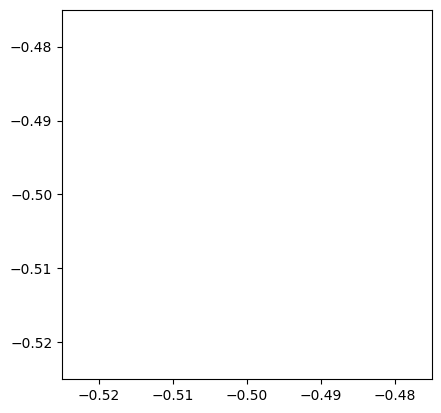

In [64]:
plot_confusion_matrix(actual_targets, predicted_targets, [
                      'BENIGN', 'Web Attack - Brute Force', 'Web Attack - Sql Injection', 'Web Attack - XSS'])

From the above confusion matrix, we can conclude that the model is mostly adequate in identifying benign traffic and brute force attacks.

## Comparison to Random Forest model

Download and open our previously developed model for this dataset: Random Forest (see https://colab.research.google.com/github/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/web-attack-detection.ipynb).

In [65]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/webattack_detection_rf_model.pkl?raw=true -O webattack_detection_rf_model.pkl

--2025-05-19 10:45:42--  https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/webattack_detection_rf_model.pkl?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fisher85/ml-cybersecurity/raw/refs/heads/master/python-web-attack-detection/webattack_detection_rf_model.pkl [following]
--2025-05-19 10:45:42--  https://github.com/fisher85/ml-cybersecurity/raw/refs/heads/master/python-web-attack-detection/webattack_detection_rf_model.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fisher85/ml-cybersecurity/refs/heads/master/python-web-attack-detection/webattack_detection_rf_model.pkl [following]
--2025-05-19 10:45:42--  https://raw.githubusercontent.com/fisher85/ml-cybersecurity/refs/heads/master/python-web-att

In [ ]:
import pickle
import sys
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential

%matplotlib inline

# Install a specific version of scikit-learn that might be compatible with the pickle file
# This might involve uninstalling the current version first
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.2

# Import scikit-learn after installing the specific version
import sklearn

# Check the installed version to confirm
print(f"Installed scikit-learn version: {sklearn.__version__}")

# Load the pickle file
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)

# Print the loaded model to verify
rfc

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 79.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done


We use the indices of the final fold of Stratified K-Folds cross-validation to split the dataset into a training set with 80% of all the samples and test set with 20% of all the samples, preserving the percentage of samples for each class.

Our Random Forest model does not need feature scaling and uses only selected features, so we need to get correct feature vectors.

In [ ]:
columns = ['Average Packet Size',
           'Flow Bytes/s',
           'Max Packet Length',
           'Fwd Packet Length Mean',
           'Fwd IAT Min',
           'Total Length of Fwd Packets',
           'Flow IAT Mean',
           'Fwd Packet Length Max',
           'Fwd IAT Std',
           'Fwd Header Length']
X_test = X.iloc[test_index]
X_test = X_test[columns]
X_test

Transform categorical labels into numeric form with simple label encoding. Note that our Random Forest model was developed for a binary classification task, so we transform labels accordingly: "0" indicates a benign instance and "1" an attack.

In [ ]:
y_test = y[test_index]
y_test = y_test.apply(lambda x: 0 if x == 'BENIGN' else 1).values

Get the Random Forest model's evaluation metrics for the final fold of data.

In [ ]:
y_pred_rfc = rfc.predict(X_test.values)

metrics_rfc = print_metrics(y_test, y_pred_rfc)
plot_confusion_matrix(y_test, y_pred_rfc, ['BENIGN', 'Web Attack'])

The Random Forest model is designed for binary classification, whereas the CNN model is designed for multiclass classification. To compare two models correctly, we change the output shape of the neural network model's dense layer so that the neural network predicts only two classes.

In [ ]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=32, padding="same",
          activation="relu", input_shape=(76, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary(line_length=100)

Train the modified neural network on the final fold of data.

In [ ]:
# Transform categorical labels into numeric form.
y = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1).values

y_eval, y_pred = train_and_validate(
    model, X, y, train_index, test_index, scaler)

Get the CNN-BiLSTM model's evaluation metrics for binary classification.

In [ ]:
metrics_nn = print_metrics(y_eval, y_pred)
plot_confusion_matrix(y_eval, y_pred, ['BENIGN', 'Web Attack'])

Finally, compare evaluation metrics for Random Forest and CNN models. Here we can see that the Random Forest model shows better results than the CNN-BiLSTM model, but the latter shows good results none the less. Further research is needed to achieve the desired performance.

In [ ]:
# Visualizing the data with a multiple bar chart.

# Scale the plot.
plt.figure(figsize=[15, 9])
plt.gca().set_ylim(0.8, 1)

# Get the data for the plot.
comparison_frame = pd.DataFrame(
    {'CNN-BiLSTM': metrics_nn, 'Random Forest': metrics_rfc},
    index=['Accuracy', 'Precision', 'Recall', 'F1'])

# Set the width of the bars.
wd = 0.3
x_pos = np.arange(1, 2*len(comparison_frame), 2)

# Plotting the multiple bar graphs on the same figure.
plt.bar(x_pos, comparison_frame['CNN-BiLSTM'], color='r', width=wd, edgecolor='k',
        label='CNN-BiLSTM')
plt.bar(x_pos+wd, comparison_frame['Random Forest'], color='y', width=wd, edgecolor='k',
        label='Random Forest')

# Add ticks, a title, and a legend.
plt.xticks(x_pos+wd, comparison_frame.index.values, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Metric', fontsize=17)
plt.ylabel('Value', fontsize=17)
plt.title(
    "Performance comparison of CNN-BiLSTM and Random Forest models.", fontsize=20)
plt.legend(loc='best', fontsize=12)

plt.show()